<a href="https://colab.research.google.com/github/anniebritton/Eco-Drought-South-Dakota/blob/main/Initial_Data_Acquisition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installs and import libraries
!pip install earthengine-api --upgrade
!pip install geemap
!pip install geopandas 
!pip install seaborn
!pip install matplotlib

import ee
import geemap.foliumap as geemap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
# reminder that if you are installing libraries in a Google Colab instance you will be prompted to restart your kernal
# this will initialise ee, and you may need to copy and paste the authentication code
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [ ]:
# mount your drive from google drive
from google.colab import drive
drive.mount('/content/drive')

In [75]:
# import and create a variable for your shapefile
AOI_path = '/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Shapefiles/Cheyenne_Basin/Cheyenne_Basin_whole.shp'

# convert the shapefile into an Earth Engine object
AOI = geemap.shp_to_ee(AOI_path)

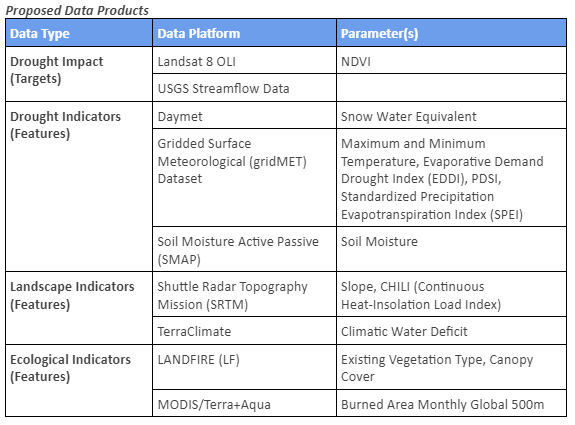

**Setting up the cloud masking and preprocessing for the MODIS NDVI Data**

*   Raw Surface Reflectance - https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD09GA
*   Preprocessed MODIS NDVI - https://developers.google.com/earth-engine/datasets/catalog/MODIS_MOD09GA_006_NDVI#bands

In [76]:
# First, a function to mask out cloudy pixels.
def mask_clouds(image):
    # Select the QA band.
    QA = image.select('state_1km')
    # Make a mask to get bit 10, the internal_cloud_algorithm_flag bit.
    bit_mask = 1 << 10
    # Return an image masking out cloudy areas.
    return image.updateMask(QA.bitwiseAnd(bit_mask).eq(0))

# Get MODIS surface reflectance image collection
mod09ga = ee.ImageCollection('MODIS/006/MOD09GA')

# Filter image collections by date and apply the mask_clouds function
mod09ga_masked = mod09ga.filterDate('2000-02-24', '2021-12-31').map(mask_clouds)

In [77]:
# Next, a function to calculate and create a new NDVI band
def get_NDVI(imagecol):
    ndvi = imagecol.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename("NDVI")
    return imagecol.addBands(ndvi).select('NDVI').copyProperties(imagecol)

# Add NDVI as a band to the image
mod09ga_NDVI = mod09ga_masked.map(get_NDVI)

**Data Set Up**

In [78]:
# MODIS NDVI
NDVI_list = [mod09ga_NDVI, 'NDVI', AOI, 1000 ]
PP_NDVI_list = [ee.ImageCollection("MODIS/MOD09GA_006_NDVI").filterDate('2000-02-24','2021-12-31'), 'NDVI', AOI, 463.313]

# Daymet
swe_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('1980-01-01','2021-12-31'), 'swe', AOI, 1000]

# gridMET Meteorology
tmin_list = [ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('1980-01-01','2021-12-31'), 'tmmn', AOI, 4638.3]
tmax_list = [ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('1980-01-01','2021-12-31'), 'tmmx', AOI, 4638.3]
precip_list = [ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('1980-01-01','2021-12-31'), 'pr', AOI, 4638.3]

# gridMET Drought
pdsi_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'pdsi', AOI, 4638.3]
spei30_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'spei30d', AOI, 4638.3] # NEED TO LOOK INTO WHAT AGGREGATION TIME MAKES SENSE
spi30_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'spi30d', AOI, 4638.3] # NEED TO LOOK INTO WHAT AGGREGATION TIME MAKES SENSE
eddi30_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'eddi30d', AOI, 4638.3] # NEED TO LOOK INTO WHAT AGGREGATION TIME MAKES SENSE

# SMAP
smam_list = [ee.ImageCollection("NASA/SMAP/SPL3SMP_E/005").filterDate('2021-03-31','2021-12-31'), 'soil_moisture_am', AOI, 9000]
smpm_list = [ee.ImageCollection("NASA/SMAP/SPL3SMP_E/005").filterDate('2015-03-31','2021-12-31'), 'soil_moisture_pm', AOI, 9000]

**Function for Creating a Timeseries of Spatially Averaged Data**

In [79]:
def spatialtimeseries(datalist):
  
    data = datalist[0]
    band = datalist[1]
    geometry = datalist[2]
    scale = datalist[3]

    # reduce the image collection to the area of study and to the correct bands
    def aoi_mean(img):
        mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=geometry, scale=scale).get(band)
        return img.set('date', img.date().format()).set('mean', mean)

    # We map this function to every image in our collection to get a new ImageCollection, but now each image has the mean value for the region of interest and the date. 
    # These are the data we’ll make our time series out of.
    aoi_reduced_imgs = data.map(aoi_mean)

    # To convert to a pandas dataframe, we dont want an ImageCollection; however, so we will reduce our images to a list of lists:
    # for each image, we have a 2-element list that contains that images date and mean value (for our point of interest)
    # each of these lists are themselves elements in our outer list, which is what we’ll convert to a dataframe
    nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

    # This nested list can be turned into a dataframe using the .DataFrame constructor. We’ll name the columns, “date” and “mean”.
    # dont forget we need to call the callback method "getInfo" to retrieve the data
    df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

    # We will also set our date column to be our index. Doing these things allows our .plot library to automatically convert the dates into nice readable dates on our axis.
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    return(df)

**Let's Run Our Function Across the Data!**

In [80]:
# NDVI
NDVI_df = spatialtimeseries(NDVI_list)
PP_NDVI_df = spatialtimeseries(PP_NDVI_list)

In [84]:
# Daymet
swe_df = spatialtimeseries(swe_list)

In [85]:
# gridMET Meteorology
tmin_df = spatialtimeseries(tmin_list)
tmax_df = spatialtimeseries(tmax_list)
precip_df = spatialtimeseries(precip_list)

In [86]:
# gridMET Drought
eddi30_df = spatialtimeseries(eddi30_list)
pdsi_df = spatialtimeseries(pdsi_list)
spei30_df = spatialtimeseries(spei30_list)
spi30_df = spatialtimeseries(spi30_list)

In [87]:
# SMAP
smam_df = spatialtimeseries(smam_list)
smpm_df = spatialtimeseries(smpm_list)

**~ Vizualize ~**

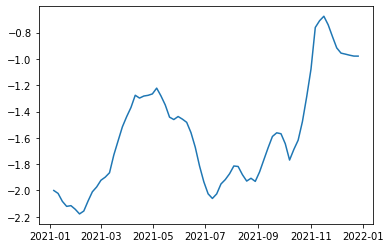

In [105]:
plt.plot(pdsi_df['2021-01-01':'2021-12-30'])

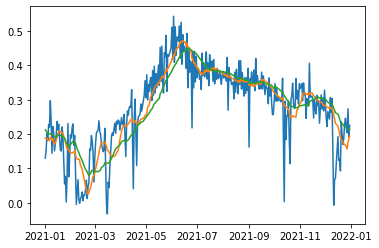

In [81]:
NDVI_df['SMA15'] = NDVI_df['mean'].rolling(15).mean()
NDVI_df['SMA30'] = NDVI_df['mean'].rolling(30).mean()
plt.plot(NDVI_df['2021-01-01':'2021-12-30'])

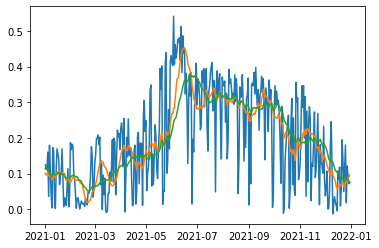

In [82]:
PP_NDVI_df['SMA15'] = PP_NDVI_df['mean'].rolling(15).mean()
PP_NDVI_df['SMA30'] = PP_NDVI_df['mean'].rolling(30).mean()
plt.plot(PP_NDVI_df['2021-01-01':'2021-12-30'])